In [60]:
import os
import numpy as np
import pandas as pd
import torch
import csv
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [61]:
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

In [62]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
print("Device : ", device) 

Device :  cuda


In [63]:
# project_path = "/content/drive/MyDrive/Colab/SRL/"
project_path = "/kaggle/input/srl-dataset/"

In [64]:
!pip install conllu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [65]:
sentences = []
srl_tags = []
csv_file = project_path + "output_dataset.csv"
with open(csv_file, 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        sentence, srl = row
        words = sentence.split()
        srl_list = srl.split()
        sentences.append(words)
        srl_tags.append(srl_list)

In [66]:
# print(srl_tags)

In [67]:
# labels = ["ARG0","ARG1","ARG2","ARG3","ARG2-ATR","ARG2-LOC","ARG2-GOL","ARG2-SOU","ARGM-PRX","ARGM-ADV",
#         "ARGM-DIR","ARGM-EXT","ARGM-MNR","ARGM-PRP","ARGM-DIS","ARGM-LOC","ARGM-MNS","ARGM-NEG","ARGM-TMP",
#           "ARGM-CAU", "NO_SRL"]
A = set()
for arr in srl_tags:
    for tag in arr:
        A.add(tag)
labels = list(A)
label_dict = {label: index for index, label in enumerate(labels)}

In [68]:
# tokenized_sentences = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences[:10]]
x_t = tokenizer.encode(sentences[0][2], add_special_tokens = False)
print(x_t)

[1520]


In [69]:
tokenized_output = tokenizer(sentences[1][5], padding=True, return_attention_mask=True)
attention_mask = tokenized_output["attention_mask"]
print("Attention Mask:", attention_mask)
print(tokenized_output)

Attention Mask: [1, 1, 1, 1]
{'input_ids': [2, 100705, 339, 3], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}


In [70]:
print(srl_tags[0][2])
print(sentences[0][2])
print(label_dict['NO_SRL'])
print(label_dict)

ARG2-ATR
मन
20
{'ARGM-MNR': 0, 'ARG2-GOL': 1, 'ARGM-MOD': 2, 'ARG-UNDEF': 3, 'ARGM-MNS': 4, 'ARG2-ATR': 5, 'ARGM-PRX': 6, 'ARG2-LOC': 7, 'ARGM-CAU': 8, 'ARGM-DIR': 9, 'ARG1': 10, 'ARGM-LOC': 11, 'ARGM-DIS': 12, 'ARGM-ADV': 13, 'ARGM-NEG': 14, 'ARGM-TMP': 15, 'ARG2': 16, 'ARGM-PRP': 17, 'ARGM-EXT': 18, 'ARG2-SOU': 19, 'NO_SRL': 20, 'ARG0': 21, 'ARG3': 22}


In [71]:
sentence_indices = []
label_indices = []
max_enc = 0
for i, sent in enumerate(sentences):
    s_t = [2]
    srl = [label_dict['NO_SRL']]
    for j, w in enumerate(sent):
        w_t = tokenizer.encode(w, add_special_tokens=False)
        max_enc = max(max_enc, len(w_t))
        s_t.extend(w_t)
        srl.extend([label_dict[srl_tags[i][j]]] * len(w_t))
    label_indices.append(srl)
    sentence_indices.append(s_t)

In [72]:
print(max_enc)
print(len(sentence_indices[1]))
print(len(label_indices[1]))

8
22
22


In [73]:
def pad(sentence_indices, label_indices):
    padded_sequences = []
    padded_labels = []
    attention_masks = []  # Attention masks list of lists
    max_length = max(len(sent) for sent in sentence_indices)
    for sent, label in zip(sentence_indices, label_indices):
        num_padding_tokens = max_length - len(sent)
        padded_sent = sent + [0] * num_padding_tokens
        padded_label = label + [label_dict['NO_SRL']] * num_padding_tokens
        attention_mask = [1] * len(sent) + [0] * num_padding_tokens
        padded_sequences.append(padded_sent)
        padded_labels.append(padded_label)
        attention_masks.append(attention_mask)
    return padded_sequences, padded_labels, attention_masks

In [74]:
pad_sentence_indices, pad_label_indices, masks = pad(sentence_indices, label_indices)

In [75]:
Xtrain = pad_sentence_indices[:-300]
train_masks = masks[:-300]
Ytrain = pad_label_indices[:-300]

Xtest = pad_sentence_indices[-300:]
test_masks = masks[-300:]
Ytest = pad_label_indices[-300:]

In [76]:
print(type(Xtrain))

<class 'list'>


---
---

<br>


In [77]:
def getEmbedding(sentence, mask):
    attention_mask = torch.tensor([mask])
    input_tensor = torch.tensor([sentence])
    with torch.no_grad():
        outputs = model(input_tensor, attention_mask = attention_mask)
    lhs = outputs.last_hidden_state
    embeddings = lhs[0]
    return embeddings

In [78]:
e1 = getEmbedding(pad_sentence_indices[1], masks[1])
print(e1.shape)
print(e1)

torch.Size([76, 768])
tensor([[-1.3179e-02, -4.9056e-04, -2.3103e-02,  ..., -1.2712e-02,
         -8.7744e-03, -1.3692e-02],
        [ 4.9362e-01, -3.4873e-01,  4.0460e-01,  ...,  3.8436e-01,
         -7.1830e-02,  1.4548e-01],
        [ 6.5916e-02, -3.1619e-01,  1.0254e-01,  ..., -1.2880e-01,
          3.9982e-01,  2.6452e-01],
        ...,
        [-1.0203e-01,  2.0529e-02,  1.1123e-01,  ..., -1.4480e-02,
         -9.9075e-03,  3.7889e-02],
        [-7.8551e-02,  8.5234e-03,  9.4996e-02,  ..., -1.3282e-02,
         -5.8353e-03,  4.1889e-02],
        [-1.8413e-02, -1.6006e-02,  3.0216e-02,  ..., -2.4423e-03,
         -1.0627e-02,  3.0827e-02]])


In [79]:
class SRLClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SRLClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out.contiguous().view(-1, self.hidden_dim))
        return out

In [80]:
input_dim = 768
hidden_dim = 32
output_dim = len(label_dict)
srl_classifier = SRLClassifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(srl_classifier.parameters(), lr = 0.001)

In [81]:
# batch_size = 32
# train_dataset = [(getEmbedding(sent), label) for sent, label in zip(Xtrain[:100], Ytrain[:100])]
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [82]:
def trainClassifier(classifier, Xtrain, Ytrain, n_epochs, optimizer):
    epoch_losses = []
    for epoch in range(n_epochs):
        classifier.train()
        running_loss = 0.0
        with tqdm(total=len(Xtrain), desc=f"Epoch {epoch+1}/{n_epochs}") as pbar:
            i = 0
            for sent, labels in zip(Xtrain, Ytrain):
                optimizer.zero_grad()
                encoded_sent = getEmbedding(sent, mask=train_masks[i])
                encoded_sent = encoded_sent.to(device)
                targets = torch.tensor(labels).to(device)
                outputs = classifier(encoded_sent).to(device)
                reshaped_outputs = outputs.view(-1, outputs.size(-1))
                reshaped_targets = targets.view(-1)
                loss = criterion(reshaped_outputs, reshaped_targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.update(1)
                i += 1
        epoch_loss = running_loss / len(Xtrain)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}\n")
    return epoch_losses


In [83]:
Epochs = 10
losses = trainClassifier(srl_classifier, Xtrain, Ytrain, Epochs, optimizer)

Epoch 1/10: 100%|██████████| 1007/1007 [01:37<00:00, 10.37it/s]


Epoch 1, Loss: 0.5162838206153877



Epoch 2/10: 100%|██████████| 1007/1007 [01:35<00:00, 10.56it/s]


Epoch 2, Loss: 0.3811200394442207



Epoch 3/10: 100%|██████████| 1007/1007 [01:36<00:00, 10.48it/s]


Epoch 3, Loss: 0.3549860859957506



Epoch 4/10: 100%|██████████| 1007/1007 [01:34<00:00, 10.64it/s]


Epoch 4, Loss: 0.3307527537053486



Epoch 5/10: 100%|██████████| 1007/1007 [01:34<00:00, 10.63it/s]


Epoch 5, Loss: 0.3091918860433592



Epoch 6/10: 100%|██████████| 1007/1007 [01:34<00:00, 10.60it/s]


Epoch 6, Loss: 0.2886880348966473



Epoch 7/10: 100%|██████████| 1007/1007 [01:34<00:00, 10.61it/s]


Epoch 7, Loss: 0.27129262760318557



Epoch 8/10: 100%|██████████| 1007/1007 [01:34<00:00, 10.67it/s]


Epoch 8, Loss: 0.25465418121018174



Epoch 9/10: 100%|██████████| 1007/1007 [01:35<00:00, 10.56it/s]


Epoch 9, Loss: 0.23927272600792313



Epoch 10/10: 100%|██████████| 1007/1007 [01:35<00:00, 10.53it/s]

Epoch 10, Loss: 0.22501838722986714



In [84]:
# print(Xtrain)
# print(Ytrain)

In [85]:
def saveModel(model, path):
    torch.save(model.state_dict(), path)

def loadModel(model, path):
    if device == 'cuda':
        model.load_state_dict(torch.load(path))
    else:
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [86]:
working_path = "/kaggle/working/"
saveModel(srl_classifier, working_path + "classifier1.pt")

In [87]:
# working_path = "/kaggle/working/"
# loadModel(srl_classifier, working_path + "classifier1.pt")

In [88]:
xt = getEmbedding(Xtrain[0], train_masks[0])
yt = torch.tensor(Ytrain[0])

In [89]:
# out = srl_classifier(xt.unsqueeze(0))

In [94]:
def evaluate(classifier, Xtest, Ytest):
    classifier.eval()
    total_samples = 0
    correct_samples = 0
    with torch.no_grad():
        for i, (sent, true_labels) in enumerate(zip(Xtest, Ytest)):
            encoded_sent = getEmbedding(sent, mask=test_masks[i])
            inputs = encoded_sent.unsqueeze(0).to(device)
            targets = torch.tensor(true_labels).to(device)
            outputs = classifier(inputs).to(device)
            predicted_labels = outputs.max(dim=1)[1].view(-1)
            total_samples += len(true_labels)
            correct_samples += (predicted_labels == targets).sum().item()
    test_accuracy = correct_samples / total_samples
    return test_accuracy

In [95]:
a1 = evaluate(srl_classifier, Xtest, Ytest)

In [96]:
print(a1)

0.9007456140350877


In [98]:
print(losses)

[0.5162838206153877, 0.3811200394442207, 0.3549860859957506, 0.3307527537053486, 0.3091918860433592, 0.2886880348966473, 0.27129262760318557, 0.25465418121018174, 0.23927272600792313, 0.22501838722986714]


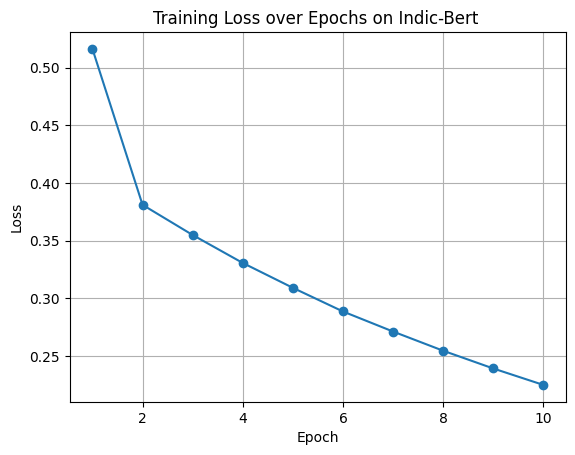

In [99]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
plt.title('Training Loss over Epochs on Indic-Bert ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [100]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(classifier, Xtest, Ytest):
    classifier.eval()
    total_samples = 0
    correct_samples = 0
    predicted_labels_all = []
    true_labels_all = []
    
    with torch.no_grad():
        for i, (sent, true_labels) in enumerate(zip(Xtest, Ytest)):
            encoded_sent = getEmbedding(sent, mask=test_masks[i])
            inputs = encoded_sent.unsqueeze(0).to(device)
            targets = torch.tensor(true_labels).to(device)
            outputs = classifier(inputs).to(device)
            predicted_labels = outputs.max(dim=1)[1].view(-1)
            total_samples += len(true_labels)
            correct_samples += (predicted_labels == targets).sum().item()
            predicted_labels_all.extend(predicted_labels.cpu().numpy())
            true_labels_all.extend(targets.cpu().numpy())
    
    # Accuracy
    accuracy = accuracy_score(true_labels_all, predicted_labels_all)
    
    # Precision, Recall, F1 Score
    precision = precision_score(true_labels_all, predicted_labels_all, average='weighted')
    recall = recall_score(true_labels_all, predicted_labels_all, average='weighted')
    f1 = f1_score(true_labels_all, predicted_labels_all, average='weighted')
    
    return accuracy, precision, recall, f1


In [102]:
accuracy, precision, recall, f1 = evaluate(srl_classifier, Xtest, Ytest)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9007456140350877
Precision: 0.866990436270892
Recall: 0.9007456140350877
F1 Score: 0.8823402962719771
